# Análisis 'rápido'  de la oferta de smartphones de la web de Media Markt:

<img src="data/imagenes/348650-30-junio-dia-iva-media-markt.png"width="400" height="400">
*** 
En este notebook se van a obtener mediante un webscraper todos los artículos ofertados en la web de Media Markt (https://tiendas.mediamarkt.es/smartphones-libres). Mediante las librerías de análisis de datos se procederá a limpiar los datos para evitar valores nulos y analizaremos los datos básicos (precio, pulgadas ...) de los terminales.  
***
**El análisis es válido para los datos recogidos hoy 25/08/2018, pero el código es reejecutable para obtener los datos del día y sacar nuevas conclusiones***
<br>
<br>

<div class="panel panel-success">
  <div class="panel-heading">Contenido</div>
  <div class="panel-body">
      <ol>
        <li>Programa de web scraping con bs4 </li>
        <li>Ontención de los datos y limpiado </li>
        <li>Análisis</li>
        <li>Conclusión</li>
      </ol>
   </div>
</div>




## 1. Web scraping con bs4 
***
El funcionamiento de este programa de web scraping es sencillo y mediante la librería  `BeautifulSoup` obtiene datos tales como precio, marca y gran parte de las especificaciones propias de los smartphones ofertados en la tienda online de *** MediaMarkt *** . El programa no está del todo optimizado y usa una forma muy rudimentaria de evitar el error 429 (Too Many Request), esperando unos segundos y volviendo a ralizar la petición; por lo tanto, al ejecutarse puede tardar unos minutos en obtener todos los datos.


### 1.1 Preparando entorno
Importamos las librerías básicas para poder realizar análisis de datos en `python` y poder visualizar los plots en el notebook. Importamos todas las que vamos a usar a lo largo de este notebook y en el programa de web scraping.

In [1]:
from bs4 import BeautifulSoup
import requests
import numpy as np
from time  import strftime
import time
import pandas as pd
import os.path as path 
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 1.2 Funciones 

In [2]:
def getDatosArticulo(URL , keys ):
    try:
    
        URL 
        check = True
        linea  = {}
        req = requests.get(URL)
        status_code = req.status_code
        contar  =0 
        while ((status_code == 429) and (contar < 5) ):
            time.sleep(2)
            req = requests.get(URL)
            status_code = req.status_code
            contar +=1
            
        
        if status_code == 200:
        
            # Pasamos el contenido HTML de la web a un objeto BeautifulSoup
            html = BeautifulSoup(req.text, "html.parser")
            
            # Conseguimos el precio, marca, fecha, dpt, dirección, descripción general y puntuación de artículos.   : 
            pricenode = html.find("div" , {"class" : "flex flex--column flex--align-end pi-info-price"})
            price = pricenode .find ("div" , {"class" : "mm-price media__price"}).getText()
            brand = html.find('div',{'class' : 'pi-info-header__brand' }).getText().replace('\n', '')            
            nombre = html.find('h1' , {'class' :"mm-text--truncate mm-text--truncate-fallback" }).getText().replace('\n', '')
                   
            # Asignamos en diccionario
            
            linea ['Direccion']= URL
            
            linea['Marca'] = brand
            linea['Precio']= float(price)
            linea['Fecha']= strftime('%x - %H:%M:%S' )
            linea ['Descripcion'] = nombre
          
            
            # Bucle principal a través de los contenedores para conseguir los datos de las especificaciones
            for i in range(30):
                entradas = html.find_all('div', {'class': "prodInfoCustomTagGroupContainer prodInfoCustomTagGroupContainer{}".format(i)})
                
                for n, entrada in enumerate(entradas):
                        # Establecemos esta condidión para que no haga iteraciones inútiles 
                        if (entrada == None):
                            break 
                        else : 
                            titulos = entrada.find_all('div', {'class': "customTag productCustomTag productCustomTag{}".format(n)})
                            
                          
                          
                        for e in titulos : 
                            name = e.find_all('div', {'class' : "customTagName productCustomTagName"})
                            strip = e.find_all('div', {'class' : "customTagValue productCustomTagValue"})
                            
                            for   h in name:
                                    name_fi = h.getText().replace('\n', '')
                                    for l in strip:
                                        strip_fi = l.getText().replace('\n', '')
                                        # Esto es por si está repetido algún apartado de las especificaciones , que en ocasiones se repiten y se entra en conflicto
                                        if ( name_fi in keys) and (name_fi not in linea.keys()):
                                            if (name_fi == 'Número de artículo'):
                                                linea[name_fi] = int (strip_fi)
                                            else :
                                                linea[name_fi] = strip_fi
            # Por si desaparece algún campo       
            for a in keys :
                if(a not in linea.keys()):
                    linea[a]= None 
                  
                                    
        else : 
            
                check = False 
        # Devuelve el diccionario y un True si todo ha ido bien 
        return linea , check 
    
    except : 
         return 
        
def GetUrlArticulo( URL_base ) : 
    
    req = requests.get(URL_base)
    statuscode = req.status_code
    contar = 0

    if (statuscode == 404):
        return

    
    while ((statuscode == 429) and (contar < 5) ):
        time.sleep(2)
        req = requests.get(URL_base)
        statuscode = req.status_code
        contar +=1
        
    html = BeautifulSoup(req.text, "html.parser")
    Max_pages = html.find_all('a' , {'class' :'button bPager gray left' }) 
    paginas = []
    direc =[]
    
 
   
    for Max in Max_pages : 
        
        t = int (Max.getText())
        paginas.append(t)

    
    
    for i in range (1 , max(paginas) ): 
        
        if (i> 1):
            url = URL_base + '/pagina{}'.format(i)
        else : 
            url = URL_base
            
        req = requests.get(url)
        statusCode = req.status_code
        while ((statusCode == 429) and (contar < 5) ):
            time.sleep(2)
            req = requests.get(url)
            statusCode = req.status_code
            contar +=1
        
        if statusCode == 200:
            
            html = BeautifulSoup(req.text, "html.parser")
            
            centro = html.find_all('div' , {'id' : 'categoryProductContainer'})
            for arti in centro : 
                texto = arti.find('a', {'class' : 'productName product1Name'}).get('href')
                if (texto[0] == '/' ):
                    direc.append('https://tiendas.mediamarkt.es'+texto +'#specifications')
                else :
                    direc.append('https://tiendas.mediamarkt.es/'+texto +'#specifications')
    
    return direc


In [3]:
# Programa principal 
start = time.clock()
print ('Ejecutando Scrapy_MM_art') 
dflis = [] 
catergo=['Sistema operativo', 'Tipo' ,'Capacidad' , 'Almacenamiento interno','Cámara','Número de artículo', 
             'Tamaño', 'Núcleos del procesador', 'NFC','Tecnología de imagen','Pulgadas',
              'Megapíxeles' ,'Velocidad ' ,'Modelo del procesador'] # Lista con las categorias a extraer en los articulos 
# Lista con los directorios principales de los cuales se tienen que extraer los URL de los artículos
listadir = ['https://tiendas.mediamarkt.es/smartphones-libres'] 
#Contadores
countgood = 0
countbad = 0 
malos = {}
for tot in listadir  :
        
        print ('\nObteniendo direcciones de articulos del directorio {}'.format(tot))
        print ('Obteniendo datos')
        articulos = GetUrlArticulo(tot)
        for art in articulos:
           
            
           
            datos =  getDatosArticulo(art , catergo)
            if (datos[1]==True):
                countgood += 1
                print ('|', end='')
                dflis.append(datos[0])
                
            
            else : 
                countbad += 1
                malos[datos[2]]=datos[3]
                print ('X', end='')
            
# Sumamos el dataframe al archivo  
df = pd.DataFrame(dflis)
   
end = time.clock()
    
texto ='''\nTiempo de ejecucion {:.4} \nCon {} articulos volcados. \nCon {} fallos de volcado.'''.format((end- start) , countgood, countbad)
      
print (texto)




Ejecutando Scrapy_MM_art

Obteniendo direcciones de articulos del directorio https://tiendas.mediamarkt.es/smartphones-libres
Obteniendo datos
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Tiempo de ejecucion 910.2 
Con 576 articulos volcados. 
Con 0 fallos de volcado.


***
Guardamos los datos en un csv por si se nos cae el Kernel o cometemos algún error limpiando los datos no tener que ejecutar el programa otra vez.

In [4]:
df.to_csv('data/datos_nolimpios.csv',index = False)

## 2. Obtención de datos y limpiado 

Una vez ya hemos ejecutado el programa obtendremos un dataframe `df` en el cual estarán todos los datos de todos los artículos. Veamos que forma tiene el dataframe:

In [5]:
df.shape

(576, 19)

Como podemos ver, el programa nos ha volcado una matriz de 576 productos(filas) con 19 atributos (columnas), pero podemos echarle un vistazo a la forma que tiene este dataframe mirando las primeras posiciones:

In [6]:
df.head(5)

,Almacenamiento interno,Capacidad,Cámara,Descripcion,Direccion,Fecha,Marca,Megapíxeles,Modelo del procesador,NFC,Núcleos del procesador,Número de artículo,Precio,Pulgadas,Sistema operativo,Tamaño,Tecnología de imagen,Tipo,Velocidad
0,32 GB,4 GB,None,"Móvil - Xiaomi MI A1, 5.5"", Full HD, 4K, 4G, 3...",https://tiendas.mediamarkt.es/p/movil-xiaomi-m...,08/25/18 - 18:34:43,Xiaomi,None,None,None,8,1394745.0,179.0,5.5,Android,None,Full HD,None,None
1,64 GB,4 GB,Sí,"Móvil - Huawei P Smart +, 6.3"", Full HD+, Kiri...",https://tiendas.mediamarkt.es/p/movil-huawei-p...,08/25/18 - 18:34:44,Huawei,None,None,Sí,8,1427900.0,289.0,None,Android 8.1 Oreo junto a EMUI 8.2,"Mas de 5,5”",IPS,None,None
2,64 GB,3 GB,None,"Móvil - iPhone X, 64 GB, Super Retina de 5.8''...",https://tiendas.mediamarkt.es/p/movil-iphone-x...,08/25/18 - 18:34:46,Apple,None,None,None,6,1382454.0,1110.0,5.8,iOS 11,5.8 pulgadas,None,QuickType,None
3,16GB,3GB,None,"Móvil - Samsung Galaxy J7 (2017), 5.5'', Full ...",https://tiendas.mediamarkt.es/p/movil-samsung-...,08/25/18 - 18:34:47,Samsung,None,None,None,8,1367560.0,199.0,5.5,Android,None,Super Amoled,None,None
4,64 GB,4 GB,None,"Pack Huawei P20 Lite, FullView 5.84"" Full HD+,...",https://tiendas.mediamarkt.es/p/pack-huawei-p2...,08/25/18 - 18:34:48,Huawei,None,None,None,8,200008050.0,291.0,5.84,Android 8 (EMUI 8.1),None,None,None,None


***Procedemos a limpiar los datos***. Como ya hemos podido observar, en el encabezamiento del dataframe tenemos varios datos nulos, por lo tanto, tenemos que encargarnos de ellos. Veamos cuántos valores nulos tenemos:

In [7]:
df.isnull().sum()

Almacenamiento interno     14
Capacidad                  66
Cámara                    332
Descripcion                 0
Direccion                   0
Fecha                       0
Marca                       0
Megapíxeles               576
Modelo del procesador     576
NFC                       457
Núcleos del procesador    120
Número de artículo          2
Precio                      0
Pulgadas                  107
Sistema operativo          38
Tamaño                    269
Tecnología de imagen      394
Tipo                      449
Velocidad                 576
dtype: int64

Vemos que tenemos muchos valores nulos, nos centraremos en rellenar los valores de la columna **Pulgadas** . Para ello usaremos la columna **Tamaño**, la cual también contiene el tamaño de la pantalla del dispositvo. Veamos cuántas filas tienen valores nulos en las columnas Pulgadas y Tamaño.

In [8]:
df[df.Pulgadas.isnull() & df.Tamaño.isnull()].isnull().any(axis=1).sum()

54

Tenemos xx filas con valores nulos en las dos columnas, por lo tanto, no podemos usar la columna **Tamaño** para cubrir los valores nulos de la columna **Pulgadas**. Otra opción es usar la información de la columna **Descripcion** en la cual se puede ver que suele aparecer el número de pulgadas.
***
Para extraer esta información utilizaremos la librería Regrex, con la cual extraeremos de la descripción del producto el tamaño de la pantalla. No será complicado ya que aparece siempre con la forma \d.\d\d"

In [9]:
def getPulgada(text):
    pulgadasRegex = re.compile(r'(\d(.\d(\d(\d)?)?)?)"')
    m1 = pulgadasRegex.search(text)
    if (m1 != None):
        return float (m1.group(1).replace(',', '.'))
    else:
        return 0.0 
    

In [10]:
for index ,ar in df.iterrows():
        df.Pulgadas =df.Pulgadas.fillna(getPulgada(df.Descripcion.loc[index]))

# Cambiamos toda la columna a float
df.Pulgadas=df.Pulgadas.astype(float)

In [11]:
# Como podemos ver, tampoco tenemos valores cero, no existen terminales con 0 pulgadas
df[df['Pulgadas']==0.0]


,Almacenamiento interno,Capacidad,Cámara,Descripcion,Direccion,Fecha,Marca,Megapíxeles,Modelo del procesador,NFC,Núcleos del procesador,Número de artículo,Precio,Pulgadas,Sistema operativo,Tamaño,Tecnología de imagen,Tipo,Velocidad


Después de limpiar volvamos a ver qué valores nulos nos quedan en los campos que nos interesan.


In [12]:
df.isnull().sum()


Almacenamiento interno     14
Capacidad                  66
Cámara                    332
Descripcion                 0
Direccion                   0
Fecha                       0
Marca                       0
Megapíxeles               576
Modelo del procesador     576
NFC                       457
Núcleos del procesador    120
Número de artículo          2
Precio                      0
Pulgadas                    0
Sistema operativo          38
Tamaño                    269
Tecnología de imagen      394
Tipo                      449
Velocidad                 576
dtype: int64

Ahora procederemos a lo mismo con el apartado **Almacenamiento interno** y limpiaremos esta columna llenando los campos nulos con los datos extraídos de la descripción. 
*** 
También procederemos a limpiar y transformar los valores de Strings a Floats.


In [13]:
def getMemo(text):
    pulgadasRegex = re.compile(r'(((\d)?(\d)?\d)(\s)?GB)')
    m1 = pulgadasRegex.search(text)
    if (m1 != None):
        return float (m1.group(2).replace(',', '.'))
    else:
        return 0.0 

In [14]:
def getMemoLimpia(text):
    pulgadasRegex = re.compile(r'(((\d)?(\d)?\d)(\s)?(GB)?)')
    m1 = pulgadasRegex.search(text)
    if (m1 != None):
        return float (m1.group(2).replace(',', '.'))
    else:
        return 0.0 

In [15]:
# Limpiamos la columna 'Almacenamiento interno' quitándole a todas las expresiones el "GB" 
for index ,ar in df.iterrows():
    if (type (df.loc[index,'Almacenamiento interno']) == str):
            df.loc[index,'Almacenamiento interno']=getMemoLimpia(df.loc[index,'Almacenamiento interno'])


In [16]:
# Llenamos los valores nulos 
for index ,ar in df.iterrows():
        df['Almacenamiento interno'] =df['Almacenamiento interno'].fillna(getMemo(df.Descripcion.loc[index]))
        

In [17]:
# Comprobamos que no tenemos valores cero
df[df['Almacenamiento interno']==0.0]

,Almacenamiento interno,Capacidad,Cámara,Descripcion,Direccion,Fecha,Marca,Megapíxeles,Modelo del procesador,NFC,Núcleos del procesador,Número de artículo,Precio,Pulgadas,Sistema operativo,Tamaño,Tecnología de imagen,Tipo,Velocidad


Comprobamos que hemos eliminado los nulos

In [18]:

df.isnull().sum()


Almacenamiento interno      0
Capacidad                  66
Cámara                    332
Descripcion                 0
Direccion                   0
Fecha                       0
Marca                       0
Megapíxeles               576
Modelo del procesador     576
NFC                       457
Núcleos del procesador    120
Número de artículo          2
Precio                      0
Pulgadas                    0
Sistema operativo          38
Tamaño                    269
Tecnología de imagen      394
Tipo                      449
Velocidad                 576
dtype: int64

Por el momento nos centraremos en los datos que tenemos limpios y realizaremos un análisis más reducido, eliminando las columnas con valores nulos y guardaremos el Dataframe por si acaso.



In [19]:
df = df.dropna(axis=1)
df.to_csv('data/datos_limpios.csv')

In [20]:
df.columns

Index(['Almacenamiento interno', 'Descripcion', 'Direccion', 'Fecha', 'Marca',
       'Precio', 'Pulgadas'],
      dtype='object')

Ahora ya podemos empezar con el análisis.

## 3. Análisis 

Para empezar nuesto análisis podemos hacer un .describe() el cual nos dará mucha información útil acerca de nuestros datos. 

In [21]:
df.describe()

,Almacenamiento interno,Precio,Pulgadas
count,576.000000,576.000000,576.000000
mean,40.486111,315.298715,5.357101
std,47.683739,247.970844,0.442000
min,2.000000,49.900000,4.000000
25%,16.000000,149.000000,5.000000
50%,32.000000,207.000000,5.500000
75%,32.000000,402.000000,5.500000
max,512.000000,1263.000000,7.000000


Con el .drecribe() ya hemos podido observar que el precio medio de la oferta de terminales es de 315,29€. Veamos que distribución tienen los datos: 

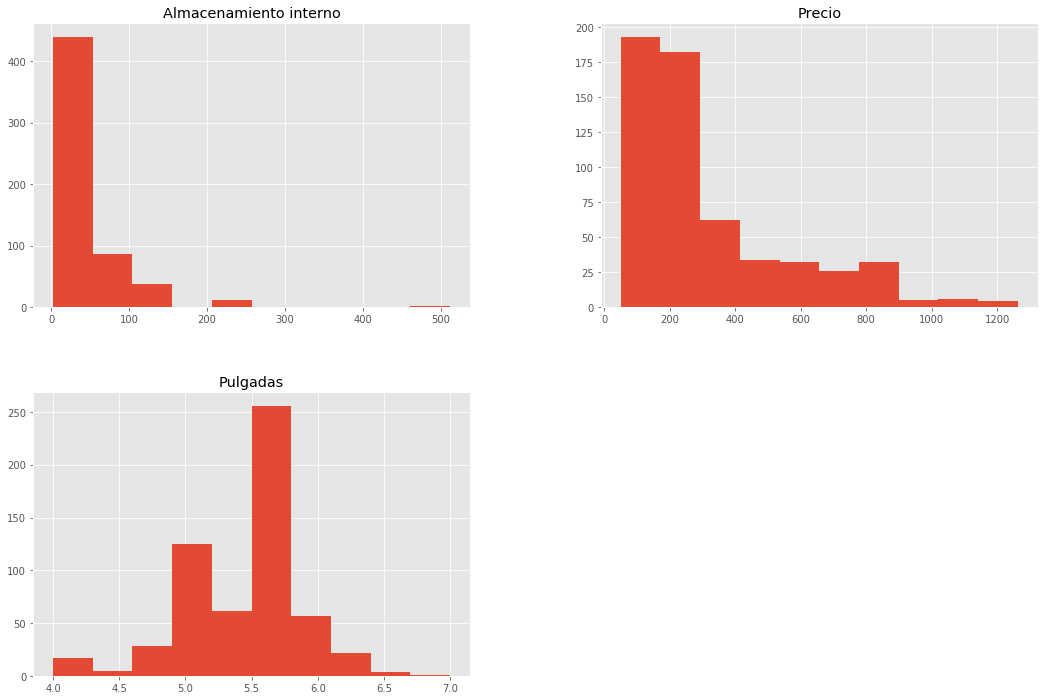

In [22]:
# Con esta función de Matplotlib podemos ver todos los histogramas
plt.style.use('ggplot')
df.hist(figsize=(18,12))
plt.show()

Como podemos ver, la mayoría de los smartphones que oferta MM se agrupan en el rango de gama media, entre 100€ y 300€. En cuanto al tamaño de las pantallas, vemos que el más ofertado es el de poco más de 5,5" 

***
Veamos ahora cómo se reparte la oferta por fabricante y el peso de cada una de las marcas.

Text(0.5,1,'Peso de cada marca')

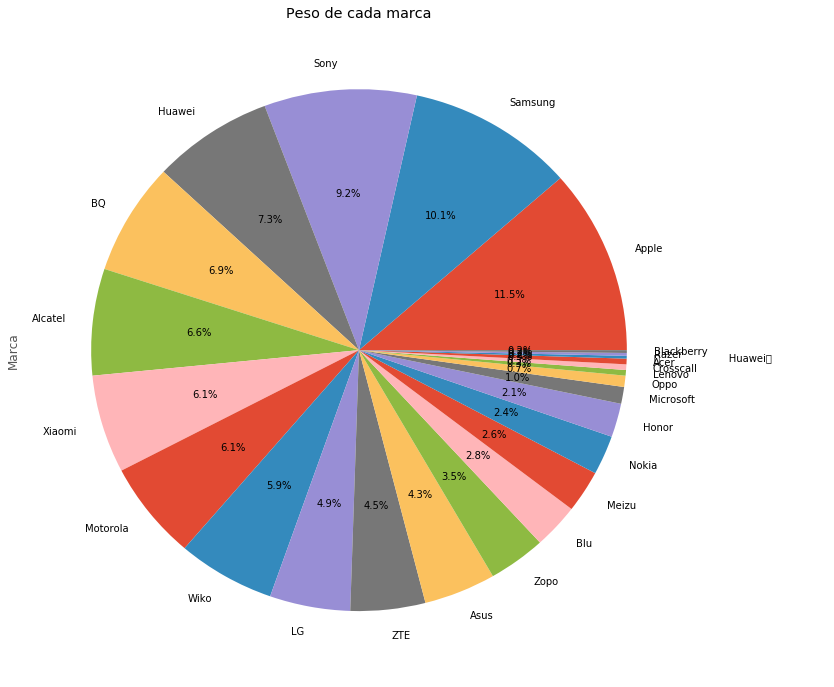

In [23]:
ax = df["Marca"].value_counts().plot(kind="pie",autopct='%1.1f%%',figsize = (12 , 12))
ax.set_title("Peso de cada marca")

Se puede observar fácilmente que Apple, Sony y Samsung tienen el mayor peso en el total de la oferta. 

Ahora podemos obtener la matriz de correlaciones y representarla con un "heatmap" para hacerla más visual:

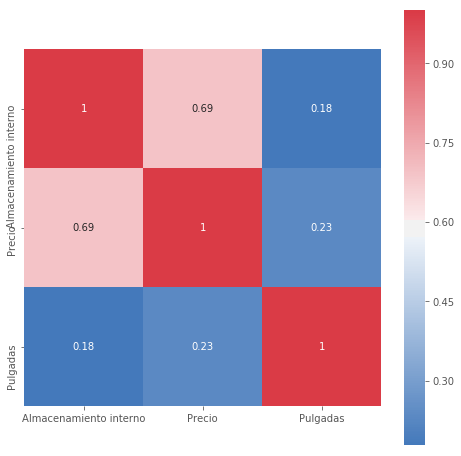

In [24]:
ax = plt.subplots(figsize=(8,8))
cmap2 = sns.diverging_palette(250, 10, as_cmap=True)
sns.heatmap(df.corr(), square=True, annot=True, cmap = cmap2)

Podemos observar que existe uns correlación positiva bastante significativa entre el precio y el almacenamiento interno. Por lo tanto, tenemos que un dispositivo con más memoria tendra un mayor precio. 

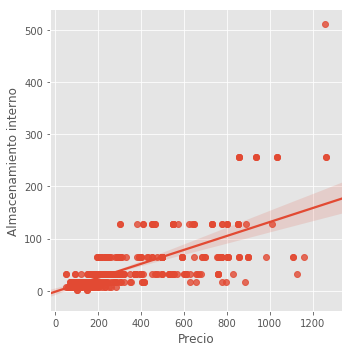

In [25]:
sns.lmplot('Precio','Almacenamiento interno',data = df)

Parece que no presenta un buen ajuste.

### Enfrentemos a los más grandes### 
Viendo que Apple, Sony y Samsung acaparan la mayor oferta de terminales (casi el 30%), vamos a centrarnos en analizar estas tres marcas.

**¿Cuál es el precio medio de los dispositivos de estas marcas?**

In [26]:
df2 =df[df.Marca.isin(['Apple','Samsung','Sony'])]
df2.groupby('Marca').agg({'Precio':np.mean})

,Precio
Marca,
Apple,735.439394
Samsung,411.584483
Sony,376.943396


Analicemos mediante la combinación de "boxplot" y "swarmplot" la dispersión de precios en cada marca. 

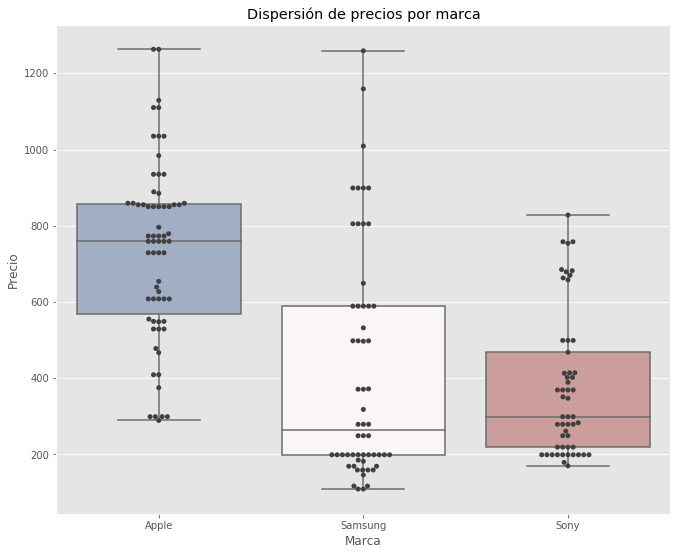

In [27]:

ax = plt.subplots(figsize=(11,9))
gr4 = sns.boxplot(x="Marca", y="Precio", data=df2,
              whis="range", palette="vlag")
gr4 = sns.swarmplot(x="Marca",y="Precio",data=df2, color=".25").set_title('Dispersión de precios por marca')


Con este gráfico nos es muy fácil identificar en qué tramo de precio se establece cada marca.
Empezando por Apple, podemos observar que sitúa la mayoría de sus terminales entre los 600€ y 820€, lo cual nos indica que esta marca centra su oferta en la gama alta (cosa que no es de extrañar). 
Por otro lado, identificamos que Samsung sitúa la mayoría de su oferta de terminales en un rango más amplio, entre los 200€ y los 600€, lo cual nos indica que centra su oferta en el mercado de gama media y gama media-alta. También podemos observar que Sony se centra en una gama muy similar, aunque un poco más acotada. 
Por último, el dato más interesante es que Samsung es la marca que más rango de precios oferta de las tres, teniendo terminales inferiores a 100€ y superiores a 1200€; esto indica su interés por situarse en todos los mercados.

Pasemos ahora a ver representado todo el conjunto de datos con un `pairplot`

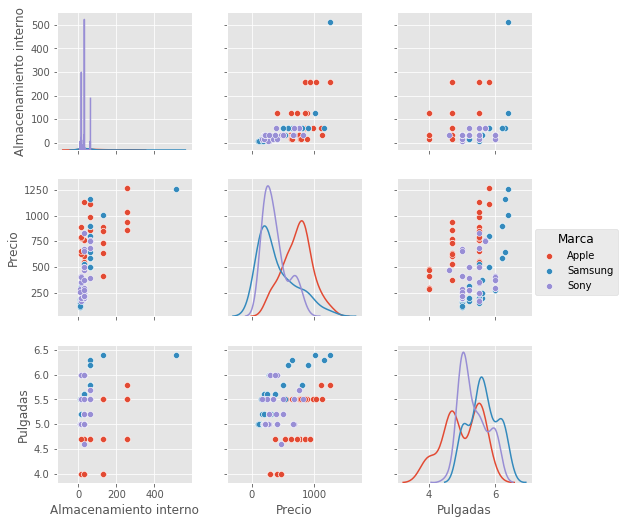

In [28]:

sns.pairplot( hue= 'Marca'
             ,diag_kind='kde'
             ,data=df2)

**¿Se puede apreciar algo?**
Si nos fijamos en el gráfico "Almacenamiento interno" vs "Precio" podemos ver que existe una cierta tendencia entre ambas variables; así mismo, podemos observar una cierta tendencia en el gráfico "Precio" vs "Pulgadas"

## 4. Conclusiones 

Con este análisis rápido de los precios de smartphones de la web de Media Markt hemos podido observar cómo centra su oferta en la gama media y cómo existe una relación entre el precio de los dispositivos móviles y el almacenamiento interno de los mismos.
También hemos estudiado por encima 'los tres más grandes' de la telefonía móvil, pudiendo apreciar que, dentro de este subgrupo, se da una relación entre precio y pulgadas. Se podría estimar un modelo de regresión lineal con la librería de machinelearning, SKLearn, pero eso lo dejo para futuros notebooks. 
